# Extract all orders from markdown blackbooks

In [ ]:
"""
Blackbook Extraction — ORDER LEVEL (All Files)
Chunking ≈ 5000 chars, extends to next Effective boundary
Issued year priority:
Filed > Dated > Approved > Effective
"""

import re
from pathlib import Path
from typing import List, Optional
import pandas as pd
from tqdm import tqdm
from pydantic import BaseModel
from langchain_openai import ChatOpenAI


# ============================================================
# CONFIG
# ============================================================

LLM_MODEL = "gpt-5-mini"

INPUT_DIR = Path(
    "/Users/othmanbensouda/Desktop/Orion/jobtalk_paper/files/blackbooks/md_format_clean"
)

OUTPUT_FILE = Path(
    "/Users/othmanbensouda/Desktop/Orion/jobtalk_paper/files/order_extraction/extracted_orders_all_files.xlsx"
)


# ============================================================
# SCHEMA
# ============================================================

class OrderEntry(BaseModel):
    order_title: str
    filed_date: Optional[str] = None
    dated_date: Optional[str] = None
    approved_date: Optional[str] = None
    effective_date: Optional[str] = None


class OrdersList(BaseModel):
    orders: List[OrderEntry]


# ============================================================
# CHUNKING (~5000 chars, extend to next Effective boundary)
# ============================================================

def chunk_page_extend_to_effective(text: str):

    text = text.replace("\r\n", "\n").replace("\r", "\n")

    effective_pattern = re.compile(
        r"Effective\s*:?\s*"
        r"(?:\d{1,2}/\d{1,2}/\d{4}"
        r"|[A-Za-z]+\s+\d{1,2},?\s+\d{4})",
        re.IGNORECASE
    )

    TARGET_SIZE = 5000
    MAX_EXTENSION = 15000  # safety cap

    chunks = []
    i = 0
    n = len(text)

    while i < n:

        tentative_end = min(i + TARGET_SIZE, n)

        match = effective_pattern.search(text, tentative_end)

        if match:
            end = match.end()

            # prevent runaway large chunk
            if end - i > MAX_EXTENSION:
                end = tentative_end
        else:
            end = n

        chunk = text[i:end].strip()

        if chunk:
            chunks.append(chunk)

        i = end

    return chunks


# ============================================================
# PROMPT
# ============================================================

def build_prompt(chunk: str) -> str:
    return f"""
Extract complete court orders.

An order usually contains a heading/title, and at least one date. You might retrieve an order that has no date associated.

Note that an order is literally any paragraph that has a date after, such as 'AMENDING RULES 47.1, 48, AND 79, RULES OF PROCEDURE FOR THE JUVENILE COURT, ON A PERMANENT BASIS
Filed: 12/12/2019
Effective 12/12/2019'

Additionally extract if present:
• Filed: date
• Dated: date
• Approved: date

Return structured output only.

TEXT:
{chunk}
""".strip()


# ============================================================
# ISSUED YEAR LOGIC (DETERMINISTIC)
# ============================================================

def extract_year(date_str):
    if not date_str:
        return None
    match = re.search(r"\d{4}", str(date_str))
    return int(match.group()) if match else None


def compute_issued_year(row):
    for field in ["filed_date", "dated_date", "approved_date", "effective_date"]:
        year = extract_year(row.get(field))
        if year:
            return year
    return None


# ============================================================
# MAIN
# ============================================================

def main():

    print("🚀 Starting extraction (all files)")

    if not INPUT_DIR.exists():
        print("❌ Input directory not found:", INPUT_DIR)
        return

    md_files = sorted(INPUT_DIR.glob("*.md"))

    if not md_files:
        print("❌ No markdown files found.")
        return

    print(f"Found {len(md_files)} markdown files.")

    llm = ChatOpenAI(
        model=LLM_MODEL,
    )

    structured_llm = llm.with_structured_output(OrdersList)

    # --------------------------------------------------
    # PRECOMPUTE TOTAL CHUNKS
    # --------------------------------------------------

    file_chunks_map = {}
    total_chunks = 0

    for f in md_files:
        text = f.read_text(encoding="utf-8", errors="ignore")
        text = re.sub(r"<!--.*?-->", "", text, flags=re.S)
        chunks = chunk_page_extend_to_effective(text)

        file_chunks_map[f] = chunks
        total_chunks += len(chunks)

    print(f"Total chunks to process: {total_chunks}")

    # --------------------------------------------------
    # PROCESS CHUNKS WITH GLOBAL tqdm
    # --------------------------------------------------

    all_rows = []

    with tqdm(total=total_chunks, desc="Chunks") as pbar:

        for f, chunks in file_chunks_map.items():

            if not chunks:
                tqdm.write(f"⚠️ No chunks in {f.name}")
                continue

            for chunk in chunks:

                try:
                    result = structured_llm.invoke(build_prompt(chunk))
                    rows = [o.model_dump() for o in result.orders]

                    for r in rows:
                        r["source_file"] = f.name

                    all_rows.extend(rows)

                except Exception as e:
                    tqdm.write(f"❌ LLM ERROR in {f.name}: {e}")

                pbar.update(1)

            # --------------------------------------------------
            # SAVE AFTER EACH FILE
            # --------------------------------------------------

            if all_rows:

                df = pd.DataFrame(all_rows)

                df["issued_year"] = df.apply(compute_issued_year, axis=1)

                df["order_title_norm"] = (
                    df["order_title"]
                    .str.lower()
                    .str.replace(r"\s+", " ", regex=True)
                    .str.strip()
                )

                df = df.drop_duplicates(
                    subset=["order_title_norm", "effective_date"],
                    keep="first",
                ).drop(columns=["order_title_norm"])

                df.to_excel(OUTPUT_FILE, index=False)

                tqdm.write(
                    f"💾 Saved after {f.name} "
                    f"({len(df)} total orders so far)"
                )

    print(f"\n✅ Finished processing all chunks.")
    print(f"Final output saved to: {OUTPUT_FILE}")



if __name__ == "__main__":
    main()


# Extract bodies of rules from orders

In [ ]:
"""
Blackbook Extraction — BODY OF RULE LEVEL
Splits previously extracted orders into one row per body of rules
- Uses project-relative paths
- Handles 1, 2, 3, 4+ rule bodies
- Reattaches bracket codes and dates to every row
- Deterministic fallback if LLM fails
- MULTITHREADED for faster processing
- EXTRACTS body of rules name to new column
"""
from pathlib import Path
from typing import List
import pandas as pd
from pydantic import BaseModel
from tqdm import tqdm
from langchain_openai import ChatOpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

# ============================================================
# CONFIG (PROJECT-RELATIVE)
# ============================================================
LLM_MODEL = "gpt-5"
MAX_WORKERS = 500

BASE_DIR = Path.cwd().parent  

INPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_orders_all_files.xlsx"
OUTPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies.xlsx"

# ============================================================
# STRUCTURED OUTPUT SCHEMA
# ============================================================
class SplitBody(BaseModel):
    body_text: str
    body_name: str  # e.g., "Arizona Rules of Civil Procedure"

class SplitBodiesList(BaseModel):
    bodies: List[SplitBody]

# ============================================================
# PROMPT
# ============================================================
def build_split_prompt(order_title: str) -> str:
    return f"""
Split this court order into separate rows, ONE ROW PER DISTINCT BODY OF RULES.

For EACH body, you must provide:
1. body_text: The full text of that row (with order number, rules, bracket code, dates)
2. body_name: JUST the name of the rule system (e.g., "Arizona Rules of Civil Procedure")

CRITICAL RULE for body_text:
Each row must include:
- The order number (e.g., "(13)")
- The specific rules for that body
- The bracket code (e.g., [R-18-0008])
- ALL dates (Filed/Effective/Dated/Approved)

CRITICAL RULE for body_name:
Extract ONLY the rule system name, such as:
- "Arizona Rules of Civil Procedure"
- "Arizona Rules of Criminal Procedure"
- "Arizona Rules of Evidence"
- "Rules of Evidence"
- "Arizona Rules of Procedure for the Juvenile Court"
- "Arizona Rule of Procedure for Eviction Actions"
- "Rules of the Supreme Court"

SPLITTING TRIGGERS:
- Semicolons separating rule systems
- "AND [RULE SYSTEM NAME]" introducing a new system
- Any new distinct named rule system

DO NOT SPLIT when "and" just connects rule numbers in the same system.

EXAMPLE (REQUIRED FORMAT):
Input: (13) ORDER AMENDING RULES OF EVIDENCE 1001, 1002, 1004, 1006, 1007, 1008; ARIZONA RULES OF CRIMINAL PROCEDURE 15.1, 15.2, 15.3; ARIZONA RULES OF PROCEDURE FOR THE JUVENILE COURT 16, 44, 73; and ARIZONA RULE OF PROCEDURE FOR EVICTION ACTIONS 10 [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019

Expected output (4 separate bodies):
Body 1: 
  body_text: "(13) ORDER AMENDING RULES OF EVIDENCE 1001, 1002, 1004, 1006, 1007, 1008; [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019"
  body_name: "Rules of Evidence"

Body 2:
  body_text: "ARIZONA RULES OF CRIMINAL PROCEDURE 15.1, 15.2, 15.3 [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019"
  body_name: "Arizona Rules of Criminal Procedure"

Body 3:
  body_text: "ARIZONA RULES OF PROCEDURE FOR THE JUVENILE COURT 16, 44, 73 [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019"
  body_name: "Arizona Rules of Procedure for the Juvenile Court"

Body 4:
  body_text: "ARIZONA RULE OF PROCEDURE FOR EVICTION ACTIONS 10 [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019"
  body_name: "Arizona Rule of Procedure for Eviction Actions"

NOW PROCESS:
{order_title}
""".strip()

# ============================================================
# PROCESSING FUNCTION
# ============================================================
def process_row(row_data):
    """Process a single row - this will be called in parallel"""
    idx, row = row_data
    
    # Each thread gets its own LLM instance
    llm = ChatOpenAI(model=LLM_MODEL)
    structured_llm = llm.with_structured_output(SplitBodiesList)
    
    try:
        result = structured_llm.invoke(
            build_split_prompt(row["order_title"])
        )
        
        bodies = [(b.body_text.strip(), b.body_name.strip()) for b in result.bodies]
        
        if not bodies:
            bodies = [(row["order_title"], "Unknown")]
            
    except Exception as e:
        # Fallback to original title on error
        bodies = [(row["order_title"], "Unknown")]
    
    # Create one row per body
    result_rows = []
    for body_text, body_name in bodies:
        new_row = row.to_dict()  # FIXED: Convert to dict
        new_row["order_title"] = body_text
        new_row["body_of_rules"] = body_name
        result_rows.append(new_row)
    
    return result_rows

# ============================================================
# MAIN
# ============================================================
def main():
    print("🚀 Starting rule-body extraction (MULTITHREADED)")
    
    if not INPUT_FILE.exists():
        print("❌ Input file not found:", INPUT_FILE)
        return
    
    df = pd.read_excel(INPUT_FILE)
    
    print(f"Processing {len(df)} orders with {MAX_WORKERS} workers...")
    
    all_rows = []
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Submit all tasks
        futures = {
            executor.submit(process_row, (idx, row)): idx 
            for idx, row in df.iterrows()
        }
        
        # Process results as they complete
        with tqdm(total=len(futures), desc="Orders") as pbar:
            for future in as_completed(futures):
                try:
                    result_rows = future.result()
                    all_rows.extend(result_rows)
                except Exception as e:
                    print(f"❌ Error processing row: {e}")
                
                pbar.update(1)
    
    final_df = pd.DataFrame(all_rows)
    
    # Reorder columns to put body_of_rules first
    if 'body_of_rules' in final_df.columns:
        cols = ['body_of_rules'] + [col for col in final_df.columns if col != 'body_of_rules']
        final_df = final_df[cols]
    
    print(f"\n📊 Columns: {list(final_df.columns)}")
    if 'body_of_rules' in final_df.columns:
        print(f"Sample body_of_rules values:\n{final_df['body_of_rules'].value_counts().head(10)}")
    
    # --------------------------------------------------------
    # DEDUPLICATION
    # --------------------------------------------------------
    final_df["rule_body_norm"] = (
        final_df["order_title"]
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    
    initial_count = len(final_df)
    
    final_df = final_df.drop_duplicates(
        subset=["rule_body_norm", "effective_date"],
        keep="first"
    ).drop(columns=["rule_body_norm"])
    
    duplicates_removed = initial_count - len(final_df)
    
    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    final_df.to_excel(OUTPUT_FILE, index=False)
    
    print("\n✅ Finished.")
    print(f"Input rows: {len(df)}")
    print(f"Output rows: {len(final_df)}")
    print(f"Duplicates removed: {duplicates_removed}")
    print("Saved to:", OUTPUT_FILE)

if __name__ == "__main__":
    main()

🚀 Starting rule-body extraction (MULTITHREADED)
Model: gpt-4o-mini
Workers: 500


Orders: 100%|██████████| 1999/1999 [01:04<00:00, 30.79it/s] 



✅ Finished.
Input rows: 1999
Output rows: 1999
Duplicates removed: 0
Saved to: /Users/othmanbensouda/Desktop/Orion/jobtalk_paper/files/order_extraction/extracted_rule_bodies.xlsx

Unknown bodies: 1,999

Sample errors (top):
RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}    1996
APIConnectionError: Connection error.                                                                                                                                                                                                                                                                                                        3

Bodies-per-order distribution (top):
1    1980
2       8
3       1


# Create an "Issued_Date" column

In [6]:
"""
Create issued_date column from filed_date, dated_date, approved_date, effective_date
"""
from pathlib import Path
import pandas as pd

# ============================================================
# CONFIG
# ============================================================
BASE_DIR = Path.cwd().parent  

INPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies.xlsx"
OUTPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies.xlsx"

# ============================================================
# MAIN
# ============================================================
def main():
    print("🚀 Creating issued_date column")
    
    df = pd.read_excel(INPUT_FILE)
    
    # Create issued_date: use first non-null value
    df['issued_date'] = (df['filed_date']
                         .fillna(df['dated_date'])
                         .fillna(df['approved_date'])
                         .fillna(df['effective_date']))
    
    df.to_excel(OUTPUT_FILE, index=False)
    
    print("✅ Done")
    print(f"Rows: {len(df)}")

if __name__ == "__main__":
    main()

🚀 Creating issued_date column
✅ Done
Rows: 2157


# Categorize (local, statewide, statewide trial)

In [ ]:
"""
Step 4 Robust Version — Deterministic + LLM Comparison

Creates:

Local Rule (Strict)
Local Rule (Expanded)
Local Rule (LLM)

Statewide Rule (Strict)
Statewide Rule (Expanded)
Statewide Rule (LLM)
"""

from pathlib import Path
import pandas as pd
import re
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# ============================================================
# CONFIG
# ============================================================

LLM_MODEL = "gpt-5"
MAX_WORKERS = 500

BASE_DIR = Path.cwd().parent

INPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies.xlsx"
OUTPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies_llm_regex.xlsx"

# ============================================================
# LLM SCHEMA
# ============================================================

class LocalClassification(BaseModel):
    is_local: int  # 1 or 0


# ============================================================
# LLM PROMPT
# ============================================================

def build_prompt(text: str) -> str:
    return f"""
Classify this court rule as either:

1 = Local Rule (applies to specific county, superior court, justice court, municipal court, etc.)
0 = Statewide Rule (applies statewide across Arizona courts)

Examples of Local:
- Rules of Practice for the Maricopa County Superior Court
- Local Rules of Civil Procedure, Mohave County Superior Court

Examples of Statewide:
- Arizona Rules of Civil Procedure
- Arizona Rules of Criminal Procedure

Return only:
is_local: 0 or 1

TEXT:
{text}
""".strip()


# ============================================================
# MAIN
# ============================================================

def main():

    df = pd.read_excel(INPUT_FILE)
    df["order_title"] = df["order_title"].astype(str)

    # ============================================================
    # STRICT DETERMINISTIC
    # ============================================================

    df["Local Rule (Strict)"] = df["order_title"].str.contains(
        r"\blocal rules?\b",
        case=False,
        na=False
    ).astype(int)

    df["Statewide Rule (Strict)"] = 1 - df["Local Rule (Strict)"]

    # ============================================================
    # EXPANDED DETERMINISTIC
    # ============================================================

    county_pattern = r"(Maricopa|Pima|Coconino|Yavapai|Mohave|Pinal|Yuma|Navajo|Gila|Cochise|Santa Cruz|La Paz|Greenlee|Graham|Apache)"
    trial_pattern = r"(Superior Court|Justice Court|Municipal Court)"

    mentions_county = df["order_title"].str.contains(
        county_pattern,
        case=False,
        na=False
    )

    mentions_trial = df["order_title"].str.contains(
        trial_pattern,
        case=False,
        na=False
    )

    expanded_local = (
        (df["Local Rule (Strict)"] == 1) |
        (mentions_county & mentions_trial)
    )

    df["Local Rule (Expanded)"] = expanded_local.astype(int)
    df["Statewide Rule (Expanded)"] = 1 - df["Local Rule (Expanded)"]

    # ============================================================
    # LLM CLASSIFICATION
    # ============================================================

    llm = ChatOpenAI(model=LLM_MODEL)
    structured_llm = llm.with_structured_output(LocalClassification)

    def classify(text):
        try:
            result = structured_llm.invoke(build_prompt(text))
            return int(result.is_local)
        except:
            return 0

    llm_results = []

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [
            executor.submit(classify, text)
            for text in df["order_title"]
        ]

        with tqdm(total=len(futures), desc="LLM Classification") as pbar:
            for future in as_completed(futures):
                llm_results.append(future.result())
                pbar.update(1)

    # Keep original order
    df["Local Rule (LLM)"] = llm_results
    df["Statewide Rule (LLM)"] = 1 - df["Local Rule (LLM)"]

    # ============================================================
    # SAVE
    # ============================================================

    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    df.to_excel(OUTPUT_FILE, index=False)

    print("\nFinished.")
    print("Saved to:", OUTPUT_FILE)

    # Quick comparison summary
    print("\nComparison:")
    print("Strict Local:", df["Local Rule (Strict)"].sum())
    print("Expanded Local:", df["Local Rule (Expanded)"].sum())
    print("LLM Local:", df["Local Rule (LLM)"].sum())


if __name__ == "__main__":
    main()


/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_37375/1790392644.py:98: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mentions_county = df["order_title"].str.contains(
/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_37375/1790392644.py:104: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mentions_trial = df["order_title"].str.contains(
LLM Classification: 100%|██████████| 2157/2157 [01:26<00:00, 24.97it/s] 



Finished.
Saved to: /Users/othmanbensouda/Desktop/Orion/jobtalk_paper/files/order_extraction/extracted_rule_bodies_local_comparison.xlsx

Comparison:
Strict Local: 190
Expanded Local: 195
LLM Local: 77


# Graphs

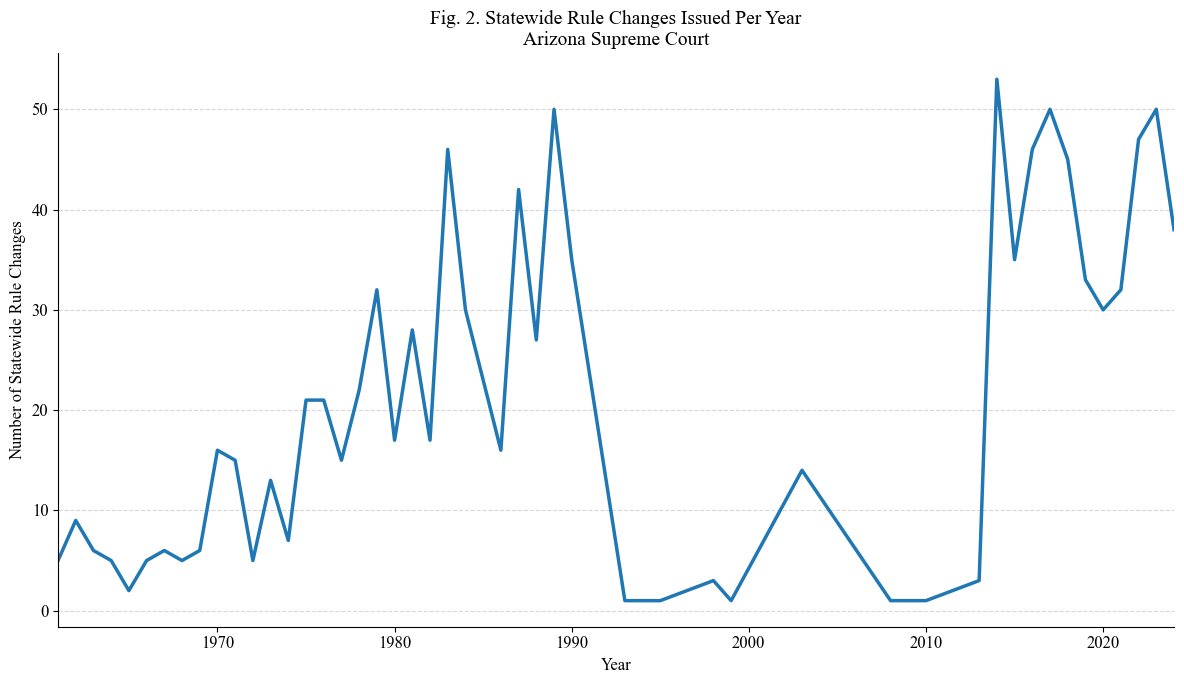

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# LOAD DATA
# ============================================================

BASE_DIR = Path.cwd().parent
file_path = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies_llm_regex.xlsx"

df = pd.read_excel(file_path)

# Ensure issued_year exists
if "issued_year" not in df.columns:
    df["issued_year"] = pd.to_datetime(
        df["issued_date"], errors="coerce"
    ).dt.year

# Keep years 1961+
df = df[df["issued_year"] >= 1961]

# ============================================================
# FILTER: STATEWIDE (REGEX CLASSIFICATION)
# ============================================================

statewide = df[df["Local Rule (Expanded)"] == 0]

yearly_counts = (
    statewide
    .groupby("issued_year")
    .size()
    .sort_index()
)

# ============================================================
# PLOT
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
})

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    yearly_counts.index,
    yearly_counts.values,
    linewidth=2.5
)

ax.set_title(
    "Fig. 2. Statewide Rule Changes Issued Per Year\nArizona Supreme Court",
    fontsize=14
)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Statewide Rule Changes")

ax.set_xlim(1961, yearly_counts.index.max())
ax.grid(axis="y", linestyle="--", alpha=0.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


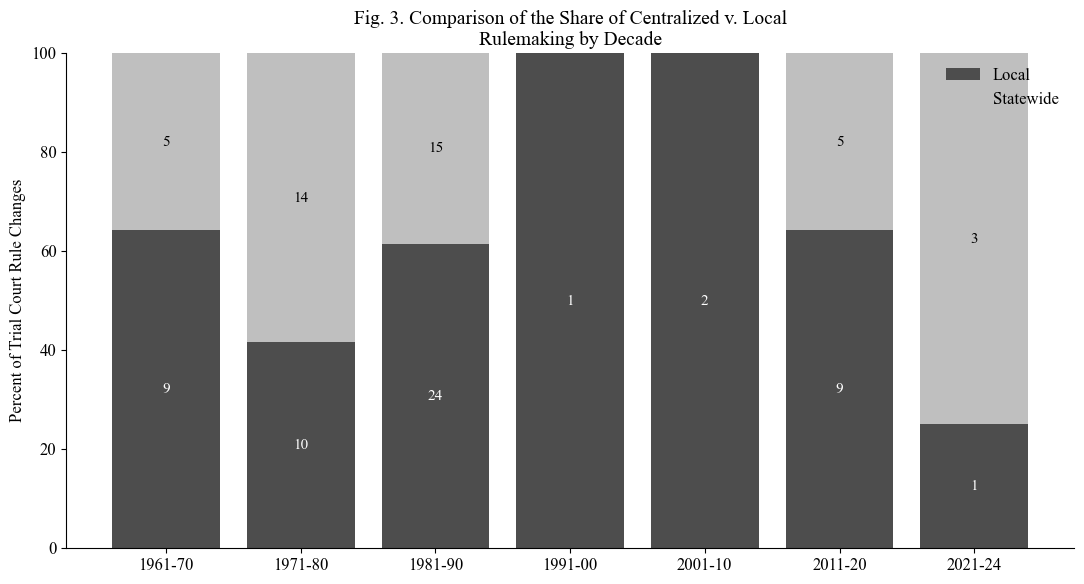

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ============================================================
# LOAD DATA
# ============================================================

BASE_DIR = Path.cwd().parent
file_path = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies_llm_regex.xlsx"

df = pd.read_excel(file_path)

# Ensure issued_year exists
if "issued_year" not in df.columns:
    df["issued_year"] = pd.to_datetime(
        df["issued_date"], errors="coerce"
    ).dt.year

df = df[df["issued_year"] >= 1961]

# ============================================================
# RESTRICT TO TRIAL COURT RULES
# ============================================================

trial_mask = df["order_title"].str.contains(
    r"Superior Court|Justice Court|Municipal Court",
    case=False,
    na=False
)

trial_df = df[trial_mask].copy()

# ============================================================
# CREATE DECADE BINS
# ============================================================

def assign_decade(year):
    if 1961 <= year <= 1970:
        return "1961-70"
    elif 1971 <= year <= 1980:
        return "1971-80"
    elif 1981 <= year <= 1990:
        return "1981-90"
    elif 1991 <= year <= 2000:
        return "1991-00"
    elif 2001 <= year <= 2010:
        return "2001-10"
    elif 2011 <= year <= 2020:
        return "2011-20"
    elif 2021 <= year <= 2024:
        return "2021-24"
    else:
        return None

trial_df["decade"] = trial_df["issued_year"].apply(assign_decade)
trial_df = trial_df.dropna(subset=["decade"])

# ============================================================
# COUNT LOCAL VS STATEWIDE (REGEX)
# ============================================================

counts = (
    trial_df
    .groupby(["decade", "Local Rule (Expanded)"])
    .size()
    .unstack(fill_value=0)
)

counts = counts.rename(columns={0: "Statewide", 1: "Local"})

# Ensure both columns exist
if "Local" not in counts.columns:
    counts["Local"] = 0
if "Statewide" not in counts.columns:
    counts["Statewide"] = 0

counts = counts[["Local", "Statewide"]]

# Compute shares
shares = counts.div(counts.sum(axis=1), axis=0)

# ============================================================
# PLOT STACKED BAR
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
})

fig, ax = plt.subplots(figsize=(11, 6))

bottom = np.zeros(len(shares))

colors = {
    "Local": "#4D4D4D",
    "Statewide": "#BFBFBF"
}

for col in ["Local", "Statewide"]:
    ax.bar(
        shares.index,
        shares[col] * 100,
        bottom=bottom,
        color=colors[col],
        label=col
    )
    bottom += shares[col] * 100

# ============================================================
# ADD COUNTS INSIDE BARS
# ============================================================

for i, decade in enumerate(shares.index):
    local_count = counts.loc[decade, "Local"]
    statewide_count = counts.loc[decade, "Statewide"]

    # Local count label
    if local_count > 0:
        ax.text(
            i,
            (shares.loc[decade, "Local"] * 100) / 2,
            f"{local_count}",
            ha="center",
            va="center",
            color="white",
            fontsize=11
        )

    # Statewide count label
    if statewide_count > 0:
        ax.text(
            i,
            shares.loc[decade, "Local"] * 100 +
            (shares.loc[decade, "Statewide"] * 100) / 2,
            f"{statewide_count}",
            ha="center",
            va="center",
            color="black",
            fontsize=11
        )

# ============================================================
# FORMATTING
# ============================================================

ax.set_ylabel("Percent of Trial Court Rule Changes")
ax.set_ylim(0, 100)

ax.set_title(
    "Fig. 3. Comparison of the Share of Centralized v. Local\nRulemaking by Decade",
    fontsize=14
)

ax.legend(frameon=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

